## 无限法则流失预测初探
> 流失预测作为我们组第一个探路性质的小项目，做的不是很严谨，主要还是在走流程的路上。对于以后具体的需求可能还需要集思广益，大家共同努力。

为了预测玩家的流失，采用监督学习的分类算法。
###### 取五周的数据：
- 训练正样本：第1.2周在玩，第3周无登录，即流失。 limit 10000
- 训练负样本：第1.2周在玩，第三周仍有登录行为，即未流失。limit 10000
- 测试样本：第4周有登录行为随机uid，limit 10000，样本真值，在第5周是否有登陆行为。

训练采用k-折叠交叉。在训练样本中分割出训练集和验证集，分别使用五种分类算法对其进行学习和预测，预测得到的预测值向量作为特征传入第二层中进行xgboost分类训练，最终等到结果。

---


In [1]:
# 载入库
import time
import datetime
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
 
import warnings
warnings.filterwarnings('ignore')
 
# 五种基础模型
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# k-交叉折叠
from sklearn.model_selection import KFold;

print("libs ok~")

libs ok~


In [2]:
# 载入数据
train_neg = pd.read_csv('neg.csv', na_values=['\\N'])
train_pos = pd.read_csv('pos.csv', na_values=['\\N'])
test = pd.read_csv('pre.csv', na_values=['\\N'])
train = pd.concat([train_neg, train_pos])

# Store our passenger ID for easy access
# PassengerId = test['PassengerId']
 
train.head(3)

,login_cnt,quest_cnt,quest_cnt.1,create_date,create_date.1,sigle_match_cnt,team_match_cnt,play_cnt,avg_kill,avg_hurt,...,spend_money,creat_use,friend_add,friend_del,tier,bp_new,bp_old,free_fuck_new,free_fuck_old,label
0,1,4,4.0,2.019072e+09,NaN,11.0,1.0,9.0,3.000000,2829.444444,...,NaN,3.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,0
1,2,4,4.0,2.019072e+09,NaN,20.0,NaN,17.0,8.647059,8165.235294,...,NaN,2.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,0
2,39,5,5.0,2.019070e+09,NaN,4.0,11.0,13.0,3.692308,3705.846154,...,NaN,4.0,2.0,NaN,7.0,1.0,NaN,NaN,NaN,0


### 数据预处理阶段

原始数据如上图，数据比较脏，包含大量的空值以及一些客观条件造成的多列，另外需要把注册日期转换为距离今天的天数等，因为我们的数据并没有枚举值，都是连续的数字，且有大有小，在这里并没有直接进行标准化或者归一化，而是以段位将数据分类，这样就忽略掉了大部分数值本身的大小差异，而且不至于数值过于连续，造成这个人登录3次还是登录4次特征就会发生变化。稀疏离散的矩阵也是机器学习中的优质数据。

In [3]:
full_data = [train, test]

for data_set in full_data:
    
    data_set.fillna(0, inplace=True)
    
    data_set.drop(['quest_cnt.1'], axis = 1)
    
    data_set['game_time'] = data_set['play_cnt'] * data_set['avg_livetime'];
    data_set.loc[(data_set['game_time'] > 0) & (data_set['game_time'] <= 1000), 'game_time'] = 1
    data_set.loc[(data_set['game_time'] >1000) & (data_set['game_time'] <= 5000), 'game_time'] = 2
    data_set.loc[(data_set['game_time'] >5000) & (data_set['game_time'] <= 10000), 'game_time'] = 3
    data_set.loc[(data_set['game_time'] >10000) & (data_set['game_time'] <= 15000), 'game_time'] = 4
    data_set.loc[(data_set['game_time'] >15000) & (data_set['game_time'] <= 20000), 'game_time'] = 5
    data_set.loc[(data_set['game_time'] >20000) & (data_set['game_time'] <= 25000), 'game_time'] = 6
    data_set.loc[(data_set['game_time'] >25000) & (data_set['game_time'] <= 30000), 'game_time'] = 7
    data_set.loc[(data_set['game_time'] >30000), 'game_time'] = 8
    
    data_set['create_date'] = data_set['create_date'] + data_set['create_date.1'] 
    data_set.drop(['create_date.1'], axis = 1, inplace=True)
    data_set['create_date'] = data_set['create_date'].astype(str)
    data_set['create_date'] = data_set['create_date'].apply(lambda x : x[0 : -4])
    data_set['create_date'] = pd.to_datetime(data_set['create_date'])
    str_today = time.strftime('%Y%m%d',time.localtime(time.time()))
    today = pd.to_datetime(str_today, format='%Y%m%d', errors='ignore')
    data_set['register_day'] = data_set['create_date'].apply(lambda x : (today - x).days)
    data_set.drop(['create_date'], axis = 1, inplace=True)
    data_set.loc[(data_set['register_day'] >= 0) & (data_set['register_day'] <= 30), 'register_day'] = 1
    data_set.loc[(data_set['register_day'] >30) & (data_set['register_day'] <= 60), 'register_day'] = 2
    data_set.loc[(data_set['register_day'] >60) & (data_set['register_day'] <= 90), 'register_day'] = 3
    data_set.loc[(data_set['register_day'] >90) & (data_set['register_day'] <= 180), 'register_day'] = 4
    data_set.loc[(data_set['register_day'] >180) & (data_set['register_day'] <= 360), 'register_day'] = 5
    data_set.loc[(data_set['register_day'] >360) & (data_set['register_day'] <= 720), 'register_day'] = 6
    data_set.loc[(data_set['register_day'] >720), 'register_day'] = 7
    
    data_set.loc[(data_set['login_cnt'] >0) & (data_set['login_cnt'] <= 5), 'login_cnt'] = 1
    data_set.loc[(data_set['login_cnt'] >5) & (data_set['login_cnt'] <= 10), 'login_cnt'] = 2
    data_set.loc[(data_set['login_cnt'] >10) & (data_set['login_cnt'] <= 30), 'login_cnt'] = 3
    data_set.loc[(data_set['login_cnt'] >30) & (data_set['login_cnt'] <= 60), 'login_cnt'] = 4
    data_set.loc[(data_set['login_cnt'] >60) & (data_set['login_cnt'] <= 100), 'login_cnt'] = 5
    data_set.loc[(data_set['login_cnt'] >100), 'login_cnt'] = 6
    
    data_set.loc[(data_set['quest_cnt'] >0) & (data_set['quest_cnt'] <= 10), 'quest_cnt'] = 1
    data_set.loc[(data_set['quest_cnt'] >10) & (data_set['quest_cnt'] <= 30), 'quest_cnt'] = 2
    data_set.loc[(data_set['quest_cnt'] >30) & (data_set['quest_cnt'] <= 50), 'quest_cnt'] = 3
    data_set.loc[(data_set['quest_cnt'] >50) & (data_set['quest_cnt'] <= 75), 'quest_cnt'] = 4
    data_set.loc[(data_set['quest_cnt'] >75), 'quest_cnt'] = 5
    data_set.drop(['quest_cnt.1'], axis = 1, inplace=True)
    
    data_set.loc[(data_set['sigle_match_cnt'] >0) & (data_set['sigle_match_cnt'] <= 5), 'sigle_match_cnt'] = 1
    data_set.loc[(data_set['sigle_match_cnt'] >5) & (data_set['sigle_match_cnt'] <= 10), 'sigle_match_cnt'] = 2
    data_set.loc[(data_set['sigle_match_cnt'] >10) & (data_set['sigle_match_cnt'] <= 20), 'sigle_match_cnt'] = 3
    data_set.loc[(data_set['sigle_match_cnt'] >20) & (data_set['sigle_match_cnt'] <= 50), 'sigle_match_cnt'] = 4
    data_set.loc[(data_set['sigle_match_cnt'] >50), 'sigle_match_cnt'] = 5
    
    data_set.loc[(data_set['team_match_cnt'] >0) & (data_set['team_match_cnt'] <= 5), 'team_match_cnt'] = 1
    data_set.loc[(data_set['team_match_cnt'] >5) & (data_set['team_match_cnt'] <= 10), 'team_match_cnt'] = 2
    data_set.loc[(data_set['team_match_cnt'] >10) & (data_set['team_match_cnt'] <= 20), 'team_match_cnt'] = 3
    data_set.loc[(data_set['team_match_cnt'] >20) & (data_set['team_match_cnt'] <= 50), 'team_match_cnt'] = 4
    data_set.loc[(data_set['team_match_cnt'] >50), 'team_match_cnt'] = 5
    
    data_set['lonely_rate'] = data_set['sigle_match_cnt'] / ( data_set['team_match_cnt'] + 1);
    
    data_set.loc[(data_set['play_cnt'] >0) & (data_set['play_cnt'] <= 5), 'play_cnt'] = 1
    data_set.loc[(data_set['play_cnt'] >5) & (data_set['play_cnt'] <= 10), 'play_cnt'] = 2
    data_set.loc[(data_set['play_cnt'] >10) & (data_set['play_cnt'] <= 20), 'play_cnt'] = 3
    data_set.loc[(data_set['play_cnt'] >20) & (data_set['play_cnt'] <= 50), 'play_cnt'] = 4
    data_set.loc[(data_set['play_cnt'] >50) & (data_set['play_cnt'] <= 100), 'play_cnt'] = 5
    data_set.loc[(data_set['play_cnt'] >100), 'play_cnt'] = 6
    
    data_set.loc[(data_set['avg_kill'] >0) & (data_set['avg_kill'] <= 0.5), 'avg_kill'] = 1
    data_set.loc[(data_set['avg_kill'] >0.5) & (data_set['avg_kill'] <= 1), 'avg_kill'] = 2
    data_set.loc[(data_set['avg_kill'] >1) & (data_set['avg_kill'] <= 3), 'avg_kill'] = 3
    data_set.loc[(data_set['avg_kill'] >3) & (data_set['avg_kill'] <= 5), 'avg_kill'] = 4
    data_set.loc[(data_set['avg_kill'] >5) & (data_set['avg_kill'] <= 10), 'avg_kill'] = 5
    data_set.loc[(data_set['avg_kill'] >10), 'avg_kill'] = 6
    
    data_set.loc[(data_set['avg_hurt'] >0) & (data_set['avg_hurt'] <= 100), 'avg_hurt'] = 1
    data_set.loc[(data_set['avg_hurt'] >100) & (data_set['avg_hurt'] <= 300), 'avg_hurt'] = 2
    data_set.loc[(data_set['avg_hurt'] >300) & (data_set['avg_hurt'] <= 500), 'avg_hurt'] = 3
    data_set.loc[(data_set['avg_hurt'] >500) & (data_set['avg_hurt'] <= 750), 'avg_hurt'] = 4
    data_set.loc[(data_set['avg_hurt'] >750) & (data_set['avg_hurt'] <= 1000), 'avg_hurt'] = 5
    data_set.loc[(data_set['avg_hurt'] >1000) & (data_set['avg_hurt'] <= 1500), 'avg_hurt'] = 6
    data_set.loc[(data_set['avg_hurt'] >1500) & (data_set['avg_hurt'] <= 2000), 'avg_hurt'] = 7
    data_set.loc[(data_set['avg_hurt'] >2000) & (data_set['avg_hurt'] <= 5000), 'avg_hurt'] = 8
    data_set.loc[(data_set['avg_hurt'] >5000), 'avg_hurt'] = 9
    
    data_set.loc[(data_set['avg_livetime'] >0) & (data_set['avg_livetime'] <= 100), 'avg_livetime'] = 1
    data_set.loc[(data_set['avg_livetime'] >100) & (data_set['avg_livetime'] <= 300), 'avg_livetime'] = 2
    data_set.loc[(data_set['avg_livetime'] >300) & (data_set['avg_livetime'] <= 500), 'avg_livetime'] = 3
    data_set.loc[(data_set['avg_livetime'] >500) & (data_set['avg_livetime'] <= 750), 'avg_livetime'] = 4
    data_set.loc[(data_set['avg_livetime'] >750) & (data_set['avg_livetime'] <= 1000), 'avg_livetime'] = 5
    data_set.loc[(data_set['avg_livetime'] >1000) & (data_set['avg_livetime'] <= 1500), 'avg_livetime'] = 6
    data_set.loc[(data_set['avg_livetime'] >1000), 'avg_livetime'] = 7
    
    data_set.loc[(data_set['rank'] >0), 'rank'] = 1
    
    data_set.loc[(data_set['spend_money'] >0) & (data_set['spend_money'] <= 1000), 'spend_money'] = 1
    data_set.loc[(data_set['spend_money'] >1000), 'spend_money'] = 2
    
    data_set.loc[(data_set['creat_use'] ==0), 'crate_use'] = 0
    data_set.loc[(data_set['creat_use'] >0) & (data_set['creat_use'] <= 3), 'crate_use'] = 1
    data_set.loc[(data_set['creat_use'] >3) & (data_set['creat_use'] <= 7), 'crate_use'] = 2
    data_set.loc[(data_set['creat_use'] >8) & (data_set['creat_use'] <= 10), 'crate_use'] = 3
    data_set.loc[(data_set['creat_use'] >10), 'crate_use'] = 4
    data_set.drop(['creat_use'], axis = 1, inplace=True)
    
    data_set.loc[(data_set['friend_add'] >0) & (data_set['friend_add'] <= 5), 'friend_add'] = 1
    data_set.loc[(data_set['friend_add'] >5) & (data_set['friend_add'] <= 10), 'friend_add'] = 2
    data_set.loc[(data_set['friend_add'] >10), 'friend_add'] = 3
    
    data_set.loc[(data_set['friend_del'] >0) & (data_set['friend_del'] <= 5), 'friend_del'] = 1
    data_set.loc[(data_set['friend_del'] >5) & (data_set['friend_del'] <= 10), 'friend_del'] = 2
    data_set.loc[(data_set['friend_del'] >10), 'friend_del'] = 3
    
    
    data_set.loc[(data_set['tier'] >0) & (data_set['tier'] <= 10), 'tier'] = 1
    data_set.loc[(data_set['tier'] >10) & (data_set['tier'] <= 30), 'tier'] = 2
    data_set.loc[(data_set['tier'] >30) & (data_set['tier'] <= 50), 'tier'] = 3
    data_set.loc[(data_set['tier'] >50) & (data_set['tier'] <= 75), 'tier'] = 4
    data_set.loc[(data_set['tier'] >75), 'tier'] = 5
    
    data_set['bp'] = data_set['bp_new'] + data_set['bp_old'] 
    data_set.drop(['bp_new'], axis = 1, inplace=True)
    data_set.drop(['bp_old'], axis = 1, inplace=True)
    
    data_set['free_fuck'] = data_set['free_fuck_new'] + data_set['free_fuck_old'] 
    data_set.drop(['free_fuck_new'], axis = 1, inplace=True)
    data_set.drop(['free_fuck_old'], axis = 1, inplace=True)
    
# train.loc[(train['create_date'] == 0) & (train['create_date.1'] == 0) & (train['label'] == 0)].head(100)
# train['create_date_real'] = train['create_date'].apply(lambda x : x if x > 0and else 0)
test.loc[(test['label'] == 0), 'label'] = 1
test.loc[(test['label'] > 1), 'label'] = 0
train['game_time'].describe()
train.head(5)

,login_cnt,quest_cnt,sigle_match_cnt,team_match_cnt,play_cnt,avg_kill,avg_hurt,avg_livetime,rank,spend_money,friend_add,friend_del,tier,label,game_time,register_day,lonely_rate,crate_use,bp,free_fuck
0,1,1,3.0,1.0,2.0,3.0,8.0,5.0,0.0,0.0,0.0,0.0,1.0,0,3.0,2.0,1.500000,1.0,0.0,0.0
1,1,1,3.0,0.0,3.0,5.0,9.0,6.0,0.0,0.0,0.0,0.0,1.0,0,6.0,2.0,3.000000,1.0,0.0,0.0
2,4,1,1.0,3.0,3.0,4.0,8.0,3.0,0.0,0.0,1.0,0.0,1.0,0,3.0,2.0,0.250000,2.0,1.0,0.0
3,2,1,5.0,1.0,5.0,5.0,9.0,6.0,0.0,0.0,0.0,0.0,2.0,0,8.0,2.0,2.500000,1.0,0.0,1.0
4,1,2,2.0,5.0,5.0,3.0,6.0,5.0,0.0,0.0,0.0,0.0,2.0,0,8.0,2.0,0.333333,2.0,0.0,1.0


In [4]:
train_input = train.dropna(axis=0,how='any')
test_input = test.dropna(axis=0,how='any')

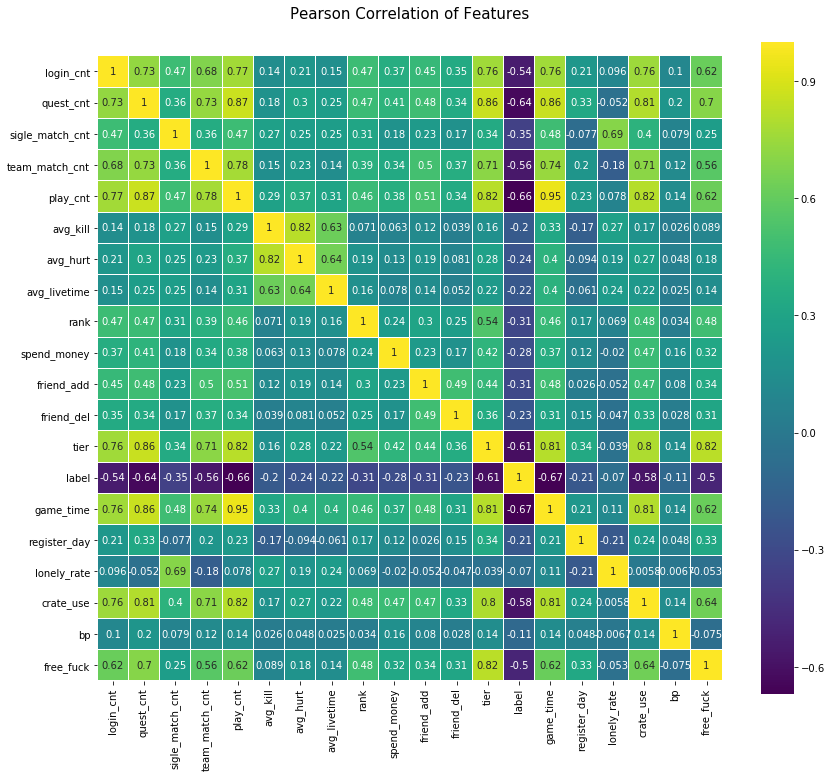

In [5]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_input.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

##### 设置参数，包一些api方便后面使用

In [6]:
ntrain = train_input.shape[0]
ntest = test_input.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [7]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
 
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
 
    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_prob(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
#         print(self.clf.fit(x,y).feature_importances_)
        return self.clf.fit(x,y).feature_importances_

In [8]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
 
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
 
        clf.train(x_tr, y_tr)
 
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
 
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

##### 参数都是网上找的，相当于直接用默认了，并没有单独经过细致的调参，后面会说

In [9]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
 
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
 
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}
 
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
 
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [10]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [11]:
y_train = train_input['label'].ravel()
train_input = train_input.drop(['label'], axis=1)
x_train = train_input.values # Creates an array of the train data
test_true = test_input['label'].ravel()
test_input = test_input.drop(['label'], axis=1)
x_test = test_input.values # Creats an array of the test data

In [12]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
 
print("Training is complete")

Training is complete


In [13]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

print("Feature impotance is complete")

Feature impotance is complete


##### 训练完成后查看对于每个模型的特征重要性，可以用来判定并删除一些特征。也可以在前面特征相关度的时候就删掉，这些都是优化并尝试的过程。

In [14]:
cols = train_input.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({
    'features': cols,
    'Random Forest feature importances': rf_feature,
    'Extra Trees  feature importances': et_feature,
    'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
})
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,login_cnt,0.064656,0.062696,0.054,0.045305
1,quest_cnt,0.194538,0.089650,0.046,0.062887
2,sigle_match_cnt,0.021560,0.020916,0.092,0.015174


In [15]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = np.random.randn(500), #set color equal to a variable
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
 
layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
 
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = np.random.randn(500), #set color equal to a variable
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
 
layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
 
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = np.random.randn(500), 
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
 
layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
 
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = np.random.randn(500), #set color equal to a variable
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]
 
layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='Europa Lost')

In [16]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
# 看一下目前的数据格式吧：
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,login_cnt,0.064656,0.062696,0.054,0.045305,0.056664
1,quest_cnt,0.194538,0.089650,0.046,0.062887,0.098269
2,sigle_match_cnt,0.021560,0.020916,0.092,0.015174,0.037412


##### 数据平均以后看一下mean值下最重要的特征

In [17]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]
 
layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

##### 看一下第一层训练出来以后的特征相关度，可以看出还是有非常高的正相关性的。

In [20]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [21]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

##### 进行最终的分类模型训练

In [22]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)
 
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
print("xgboost train complete")
predictions = gbm.predict(x_test)

xgboost train complete


##### 偷窥一下真值和训练值，从头尾露出来的六个样本来看，预测全部准确，说明此实验的可行性。

In [33]:
print(predictions)
print(test_true)

[1 0 1 ... 0 0 1]
[1. 0. 1. ... 0. 0. 1.]


##### 全部的数据精度如下，目前看来还是不太理想的。问题放在最后归纳吧

In [23]:
from sklearn import metrics 
def get_scores(y_true, y_predicet):
    acc_score = metrics.accuracy_score(y_true,y_predicet)
    pre_score = metrics.precision_score(y_true,y_predicet)
    recall = metrics.recall_score(y_true,y_predicet)
    F1 = metrics.f1_score(y_true,y_predicet)
    print('准确率：',acc_score)
    print('精确率：',pre_score)
    print('召回率：',recall)
    print('F1-score:',F1)
    
get_scores(test_true, predictions)

准确率： 0.7761301616723304
精确率： 0.7292289300657502
召回率： 0.8178770949720671
F1-score: 0.7710132715399199


##### 选出第一层的两个模型看一下具体的学习曲线。

In [35]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<function matplotlib.pyplot.show(*args, **kw)>

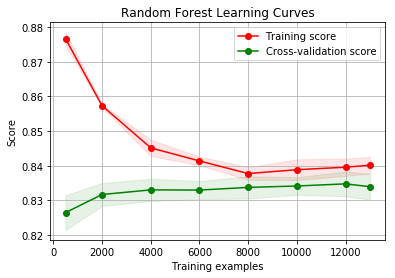

In [38]:
# rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)


train_plot = train.dropna(axis=0,how='any')
train_plot = train_plot.sample(frac=1)
# train_plot.drop(['sigle_match_cnt', 'team_match_cnt', 'bp', 'rank', 'spend_money', 'register_day'], axis = 1, inplace=True)

y_plot_train = train_plot['label'].ravel()
train_plot = train_plot.drop(['label'], axis=1)
x_plot_train = train_plot.values 

title = "Random Forest Learning Curves"
plot_learning_curve(RandomForestClassifier(**rf_params), title, x_plot_train, y_plot_train, cv=None,  n_jobs=4, train_sizes=[500, 2000, 4000, 6000, 8000, 10000, 12000, 13000])
plt.show 

In [40]:
# title = "Extra Trees Learning Curves"
# plot_learning_curve(ExtraTreesClassifier(**et_params), title, x_plot_train, y_plot_train, cv=None,  n_jobs=4, train_sizes=[500, 2000, 4000, 6000, 8000, 10000, 12000, 13000])
# plt.show 

In [41]:
# title = "Ada Boost Learning Curves"
# plot_learning_curve(AdaBoostClassifier(**ada_params), title, x_plot_train, y_plot_train, cv=None,  n_jobs=4, train_sizes=[500, 2000, 4000, 6000, 8000, 10000, 12000, 13000])
# plt.show 

<function matplotlib.pyplot.show(*args, **kw)>

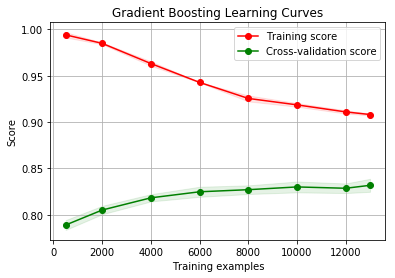

In [42]:
title = "Gradient Boosting Learning Curves"
plot_learning_curve(GradientBoostingClassifier(**gb_params), title, x_plot_train, y_plot_train, cv=None,  n_jobs=4, train_sizes=[500, 2000, 4000, 6000, 8000, 10000, 12000, 13000])
plt.show 

In [43]:
# title = "SVC Learning Curves"
# plot_learning_curve(SVC(**svc_params), title, x_plot_train, y_plot_train, cv=None,  n_jobs=4, train_sizes=[500, 2000, 4000, 6000, 8000, 10000, 12000, 13000])
# plt.show 

## 总结一下
这两个学习曲线比较有代表性，第一个随机森林看起来很稳定，收敛趋势明显，但是准确率不是很高，也就是有一点欠拟合的倾向。
第二个GBDT看起来性能更好，但是训练样本准确率高于90%，验证集和训练集差距较大，有过拟合的倾向。

对于这个项目，如果还需要进一步的优化，需要从特征开始处理，特征的根源来自人脑的奇思妙想，有了更多更相关的特征，后面再对模型进行优化调参，可以现针对某一个模型，进行增减特征，添加正则化项，等等方式，依据学习曲线和模型的准确率来进行调参。

另外因为是实验性质的项目，其实样本采集本身也似乎有很多不合理性的，**譬如人机局和实战局的分离，疑似外挂数据的删除，亚洲玩家和欧美玩家的分离，正负样本更科学的判定，负反馈的增加，局内交互动作的增加，延迟的考虑，只有一局人机记录的样本和成熟玩家的数据是否应该放在一起，等等等等**。后面是不是也要为采集更多的数据增加osslog，或者引入kafka我们自己处理非结构化日志，有了足够的数据，有了现成的平台，是否可以对玩法进行评估，对活动进行评估，或是对商城物品的后台打分评估，有了流式实时性是不是可以对测试服的改动快速给出数据层面的决策支持，对于我们服务器是否可可以就得到一个重要业务指标的秒级监控，能想象空间还有很多，个人能力有限。

机器学习的根本在于特征，那晚正哥看了特征相关性的图后提出一个增加一个局内总游戏时间的特征是不是要比局数和平均游戏时间更好，尝试以后发现。局内总游戏时间是正相关最强的一个特征，肯定还有很多特征需要去思考去发现。这次的实验就先到这里，因为idex上cpu算力槽老是空的，代码是跑在本地的，移植仅需求改载入数据的地方，以及加一个一个画图的包即可。